# Drug consumption (quantified) Data Set
Abstract: Classify type of drug consumer by personality data

Number of Instances: 1885

Number of Attributes: 32

Date Donated: 2016-10-17

Original database: http://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Predict if a person is a drug consumer based on their personality data and demographics


In [15]:
# Libraries  
library(data.table)
library(readr)
library(tree)
library(randomForest)
library(gbm) 
library(ggplot2)
library(ggfortify)
library(e1071)      # svm
library(kohonen)
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra) # clustering algorithms & visualization
library(mclust)     # gaussian mixture models

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Package 'mclust' version 5.3
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: 'mclust'

The following object is masked from 'package:purrr':

    map

The following object is masked from 'package:kohonen':

    map



In [17]:
############ Read database #################################################

dat <- fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data")

# Add labels to the database
names(dat) <- c("ID","Age","Gender","Education", "Country","Ethnicity", "Nscore", "Escore","Oscore", "Ascore", "Cscore", "Impulsive","SS", "Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke", "Crack", "Ecstasy", "Heroin", "Ketamine", "Legalh", "LSD", "Meth", "Mushrooms", "Nicotine", "Semer", "VSA")
attach(dat)


Warning message in download.file(input, tmpFile, method = method, mode = "wb", quiet = !showProgress):
"downloaded length 241664 != reported length 346695"Warning message in fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"):
"Discarded single-line footer: <<1320,0.49788,->>"The following objects are masked from dat (pos = 3):

    Age, Alcohol, Amphet, Amyl, Ascore, Benzos, Caff, Cannabis, Choc,
    Coke, Country, Crack, Cscore, Ecstasy, Education, Escore,
    Ethnicity, Gender, Heroin, ID, Impulsive, Ketamine, Legalh, LSD,
    Meth, Mushrooms, Nicotine, Nscore, Oscore, Semer, SS, VSA



In [18]:
############ Pre processing #################################################

# Identify participants who answered that they used Semeron (fake drug)
sum(Semer!="CL0")*1 # 8 participants answered Yes to Semeron
dat = subset(dat, Semer=="CL0")

# We wil classify subjects in onlt two categories: "users" (U) and "non users" (NU)
# Create categories of drug users:
# 0:= Non Users 
#      CL0: Never used
#      CL1: over a decade
# 1:= Users
#     CL2 to CL6

[1] 2

In [19]:
# Step 1:= Translate the info from codes to understandable labels 

# Age
levels(dat$Age) <- c(levels(dat$Age), "18-24", "25-34", "35-44", "45-54", "55-64","65+")
dat$Age[dat$Age == '-0.95197'] <- "18-24"
dat$Age[dat$Age == '-0.07854'] <- "25-34"
dat$Age[dat$Age == '0.49788'] <- "35-44"
dat$Age[dat$Age == '1.09449'] <- "45-54"
dat$Age[dat$Age == '1.82213'] <- "55-64"
dat$Age[dat$Age == '2.59171'] <- "65+"

# Gender
levels(dat$Gender) <- c(levels(Gender), "Female", "Male")
dat$Gender[Gender == '0.48246'] <- "Female"
dat$Gender[Gender == '-0.48246'] <- "Male"

# Education
levels(dat$Education) <- c(levels(dat$Education), "Left school before 16 years", 
                            "Left school at 16 years", "Left school at 17 years", 
                            "Left school at 18 years",
                            "Some college or university, no certificate or degree",
                            "Professional certificate/ diploma","University degree",
                            "Masters degree", "Doctorate degree")
dat$Education[dat$Education == '-2.43591'] <- "Left school before 16 years"
dat$Education[dat$Education =='-1.7379'] <- "Left school at 16 years"
dat$Education[dat$Education == '-1.43719'] <- "Left school at 17 years"
dat$Education[dat$Education == '-1.22751'] <- "Left school at 18 years"
dat$Education[dat$Education =='-0.61113'] <-  "Some college or university, no certificate or degree"
dat$Education[dat$Education == '-0.05921'] <- "Professional certificate/ diploma"
dat$Education[dat$Education == '0.45468'] <- "University degree"
dat$Education[dat$Education == '1.16365'] <- "Masters degree"
dat$Education[dat$Education == '1.98437'] <- "Doctorate degree"

# Country
levels(dat$Country) <- c(levels(dat$Country), "Australia", "Canda","New Zealand","Other","Republic of Ireland","UK","USA")
dat$Country[dat$Country == '-0.09765'] <- "Australia"
dat$Country[dat$Country == '0.24923'] <- "Canada"
dat$Country[dat$Country == '-0.46841'] <- "New Zealand"
dat$Country[dat$Country == '-0.28519'] <- "Other"
dat$Country[dat$Country == '0.21128'] <- "Republic of Ireland"
dat$Country[dat$Country == '0.96082'] <- "UK"
dat$Country[dat$Country == '-0.57009'] <- "USA"

# Ethnicity
levels(dat$Ethnicity) <- c(levels(dat$Ethnicity), "Asian", "Black","Mixed-Black/Asian","Mixed-White/Asian","Mixed-White/Black","Other","White")
dat$Ethnicity[dat$Ethnicity == '-0.50212'] <- "Asian "
dat$Ethnicity[dat$Ethnicity == '-1.10702'] <- "Black"
dat$Ethnicity[dat$Ethnicity == '1.90725'] <- "Mixed-Black/Asian"
dat$Ethnicity[dat$Ethnicity == '0.126'] <- "Mixed-White/Asian"
dat$Ethnicity[dat$Ethnicity == '-0.22166'] <- "Mixed-White/Black"
dat$Ethnicity[dat$Ethnicity == '0.1144'] <- "Other"
dat$Ethnicity[dat$Ethnicity == '-0.31685'] <- "White"


Warning message in `[<-.data.table`(x, j = name, value = value):
"Supplied 1316 items to be assigned to 1314 items of column 'Gender' (2 unused)"Warning message in `[<-.data.table`(x, j = name, value = value):
"NAs introducidos por coerción"Warning message in `[<-.data.table`(x, j = name, value = value):
"Coerced 'character' RHS to 'double' to match the column's type. Either change the target column ['Gender'] to 'character' first (by creating a new 'character' vector length 1314 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'double' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."Warning message in `[<-.data.table`(x, j = name, value = value):
"Supplied 1316 items to be assigned to 1314 items of column 'Gender' (2 unused)"Warning message in `[<-.data.table`(x, j = name, value = value):
"NAs introducidos por coerción"Warning

In [21]:
# Step 2:= Create variables for Logistic regression
logData <- ifelse(dat[,14:32] == "CL0"| dat[,14:32] == "Cl1", 0, 1)
# Create variables for Classification Tree
classTreeData <- ifelse(dat[,14:32] == "CL0"| dat[,14:32] == "Cl1","NU","U")

dat = data.frame(dat, logData, classTreeData) # <- dataset ready for analysis

write.csv2(dat,'drugConsumption.csv',row.names = F)

# Step 3:= Scaling and centering of numerical variables
numDat <- apply(dat[,7:13],2,scale)

# Step 4:= remove missing values
numDat <-na.omit(numDat)


In [22]:
# Compute PCA, use cener & scale parameters if not sure if data has been centered and scaled
dat.pca <- prcomp(numDat) # , center = TRUE, scale = TRUE)
summary(dat.pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5    PC6    PC7
Standard deviation     1.4792 1.3683 0.9364 0.83612 0.75416 0.6698 0.5886
Proportion of Variance 0.3126 0.2675 0.1252 0.09987 0.08125 0.0641 0.0495
Cumulative Proportion  0.3126 0.5800 0.7053 0.80516 0.88641 0.9505 1.0000

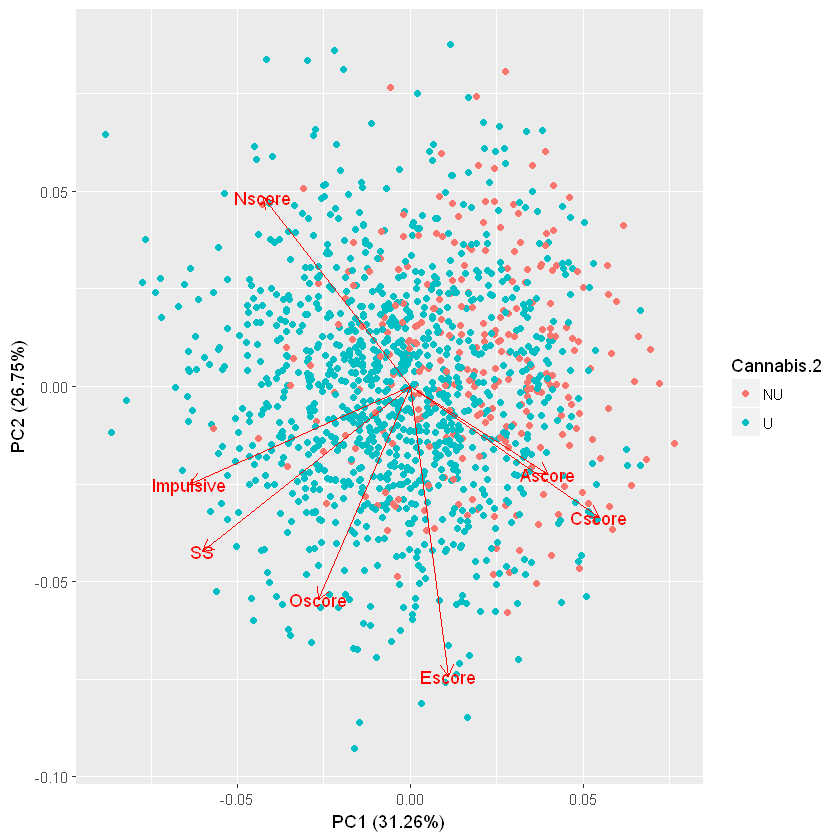

In [23]:
autoplot(dat.pca, data = dat, colour = 'Cannabis.2',labels=rownames(numDat), loadings = TRUE,loadings.label = TRUE)

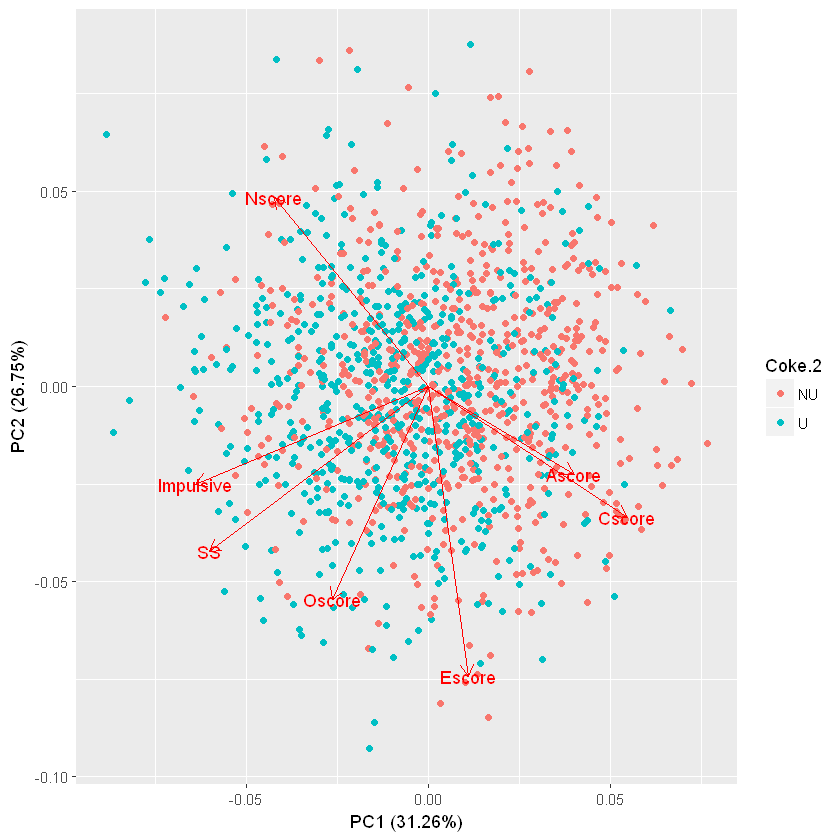

In [24]:
autoplot(dat.pca, data = dat, colour = 'Coke.2',labels=rownames(numDat), loadings = TRUE,loadings.label = TRUE)


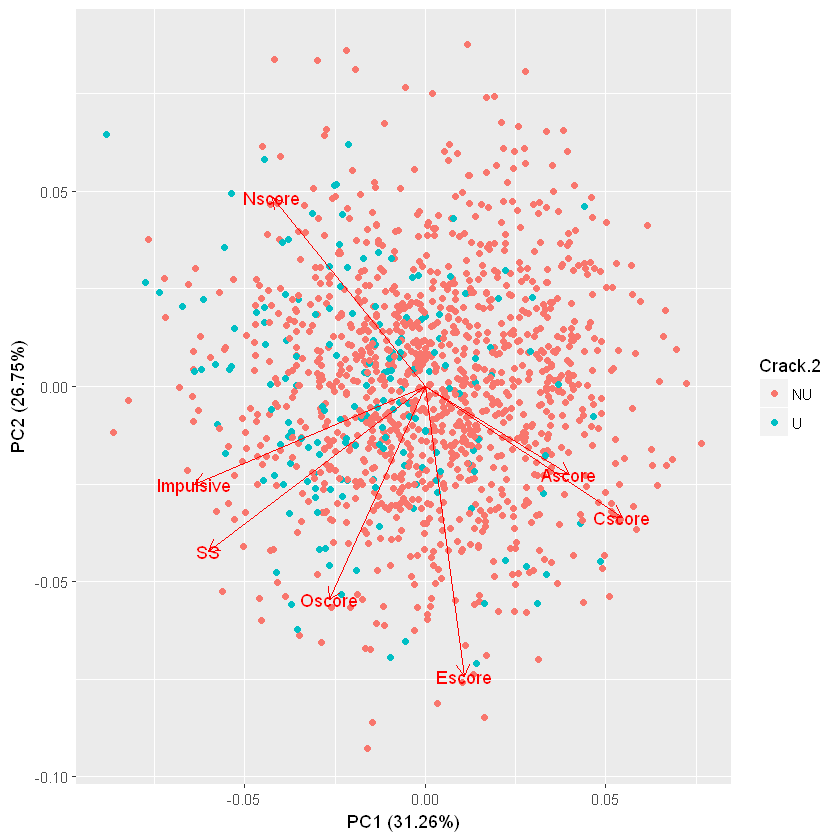

In [25]:
autoplot(dat.pca, data = dat, colour = 'Crack.2',labels=rownames(numDat), loadings = TRUE,loadings.label = TRUE)


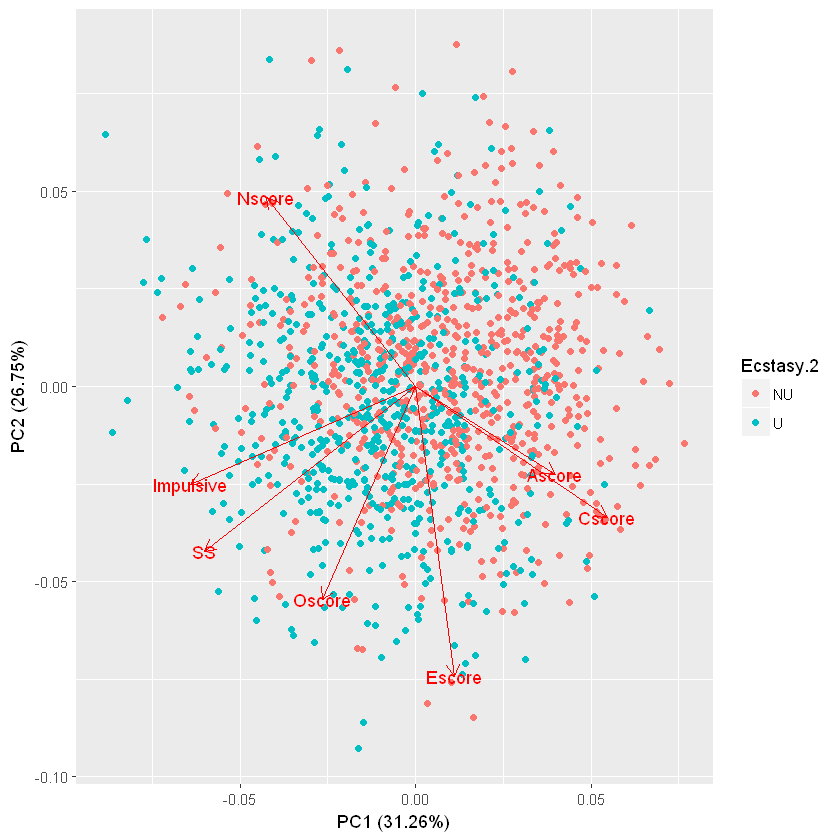

In [26]:
autoplot(dat.pca, data = dat, colour = 'Ecstasy.2',labels=rownames(numDat), loadings = TRUE,loadings.label = TRUE)


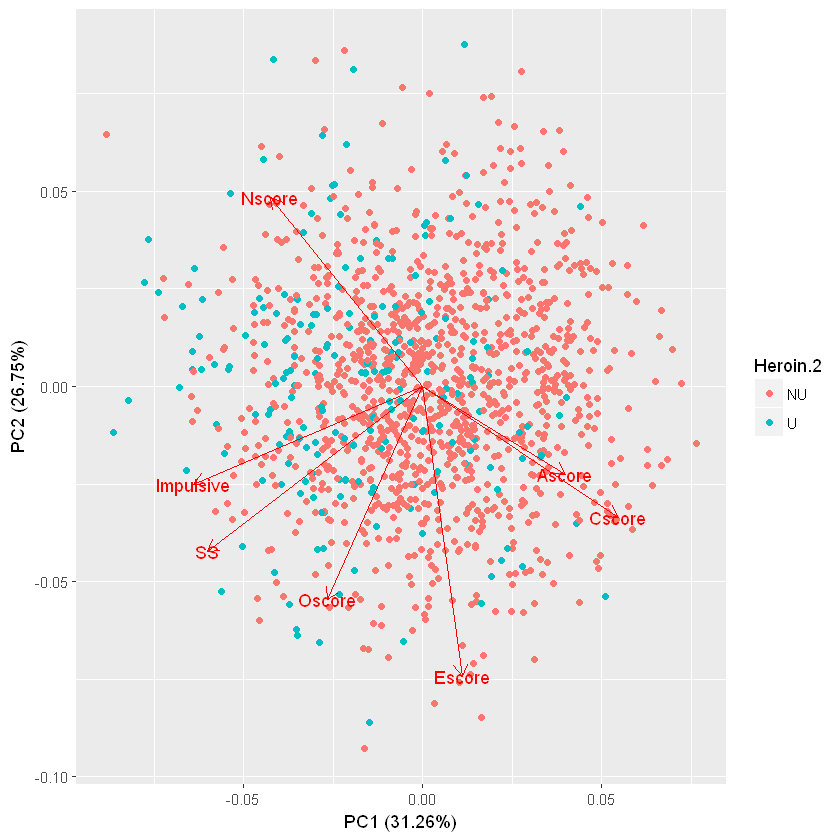

In [27]:
autoplot(dat.pca, data = dat, colour = 'Heroin.2',labels=rownames(numDat), loadings = TRUE,loadings.label = TRUE)


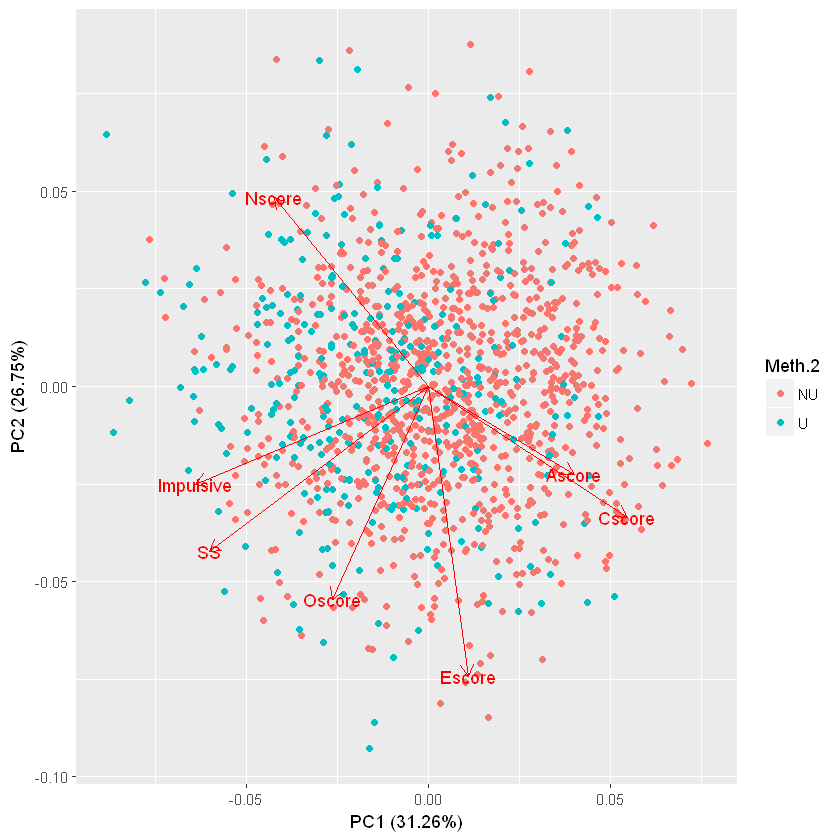

In [29]:
autoplot(dat.pca, data = dat, colour = 'Meth.2',labels=rownames(numDat), loadings = TRUE,loadings.label = TRUE)